<a href="https://colab.research.google.com/github/jocelync-invisible/icu-length-of-stay-prediction/blob/main/Baysian%20Linear%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np


df = pd.read_csv('mimiccomb_processed.csv')

In [3]:
df.head()

,Unnamed: 0,subject_id,gender,anchor_age,hadm_id,insurance,marital_status,stay_id,los,org_name,positive_culture,microbio_group_comb,microbio_group_Unknown,microbio_group_fungi_yeasts,microbio_group_gram_negative_rods,microbio_group_gram_positive_cocci,microbio_group_gram_positive_rods,microbio_group_mixed_flora
0,8,10000032,0,52,29079034,1,0.0,39553978.0,0.410266,Unknown,0,Unknown,1,0,0,0,0,0
1,9,10000032,0,52,29079034,1,0.0,39553978.0,0.410266,Unknown,0,Unknown,1,0,0,0,0,0
2,10,10001217,0,55,24597018,0,1.0,37067082.0,1.118032,Unknown,0,Unknown,1,0,0,0,0,0
3,11,10001217,0,55,24597018,0,1.0,37067082.0,1.118032,Unknown,0,Unknown,1,0,0,0,0,0
4,12,10001217,0,55,24597018,0,1.0,37067082.0,1.118032,FUSOBACTERIUM NUCLEATUM,1,gram_negative_rods,0,0,1,0,0,0


In [4]:
df.loc[df['positive_culture'] == 0, 'microbio_group_comb'] = 'NaN'

In [5]:
df.columns

Index(['Unnamed: 0', 'subject_id', 'gender', 'anchor_age', 'hadm_id',
       'insurance', 'marital_status', 'stay_id', 'los', 'org_name',
       'positive_culture', 'microbio_group_comb', 'microbio_group_Unknown',
       'microbio_group_fungi_yeasts', 'microbio_group_gram_negative_rods',
       'microbio_group_gram_positive_cocci',
       'microbio_group_gram_positive_rods', 'microbio_group_mixed_flora'],
      dtype='object')

In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [7]:
df.to_csv('mimiccomb_processed_updated.csv', index=False)

In [8]:
df.isnull().sum()

,0
subject_id,0
gender,0
anchor_age,0
hadm_id,0
insurance,0
marital_status,59
stay_id,0
los,0
org_name,0
positive_culture,0


In [9]:
df["los"] = df["los"].astype(int)
df["stay_id"] = df["stay_id"].astype(int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   subject_id                          2731 non-null   int64 
 1   gender                              2731 non-null   int64 
 2   anchor_age                          2731 non-null   int64 
 3   hadm_id                             2731 non-null   int64 
 4   insurance                           2731 non-null   int64 
 5   marital_status                      2672 non-null   object
 6   stay_id                             2731 non-null   int64 
 7   los                                 2731 non-null   int64 
 8   org_name                            2731 non-null   object
 9   positive_culture                    2731 non-null   int64 
 10  microbio_group_comb                 2731 non-null   object
 11  microbio_group_Unknown              2731 non-null   int6

In [ ]:
# handle missing data in marital_status
df["marital_status"].fillna("Unknown", inplace=True)

<ipython-input-10-24b0ad69bee0>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["marital_status"].fillna("Unknown", inplace=True)


In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [12]:
num_cols = ["anchor_age"]
cat_cols = ["gender", "insurance", "marital_status", "positive_culture",
    "microbio_group_comb", "microbio_group_Unknown", "microbio_group_fungi_yeasts",
    "microbio_group_gram_negative_rods", "microbio_group_gram_positive_cocci",
    "microbio_group_gram_positive_rods", "microbio_group_mixed_flora"]
org_col = ["org_name"]


# encode `org_name` only for rows with a positive culture
df_org_pca = df[df["positive_culture"] == 1][["org_name"]].copy()

df["org_name"] = df["org_name"].fillna("Missing")

org_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
org_encoded = org_encoder.fit_transform(df_org_pca)

In [13]:
# Run PCA to reduce dimensionality of org_name
pca_org = PCA(n_components=0.95)
org_pca_transformed = pca_org.fit_transform(org_encoded)

In [14]:
# Convert to DataFrame
org_pca_df = pd.DataFrame(org_pca_transformed, columns=[f'Org_PC{i+1}' for i in range(org_pca_transformed.shape[1])])

# Return original index and missing values
df_org_pca = df_org_pca.reset_index(drop=True)
org_pca_df = org_pca_df.set_index(df_org_pca.index)

# Merge PCA-Reduced org_name back into original dataset
df = df.reset_index(drop=True)
df = df.join(org_pca_df)

In [15]:
# Preprocessing Pipeline for Remaining Features
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

In [16]:
# Convert all categorical columns to strings
df[cat_cols] = df[cat_cols].astype(str)

# Transform the data
df_transformed = preprocessor.fit_transform(df)

In [17]:
# Apply final PCA to reduce overall dimensions
pca = PCA(n_components=0.95)
pca_transformed = pca.fit_transform(df_transformed)

pca_df = pd.DataFrame(data=pca_transformed, columns=[f'PC{i+1}' for i in range(pca_transformed.shape[1])])

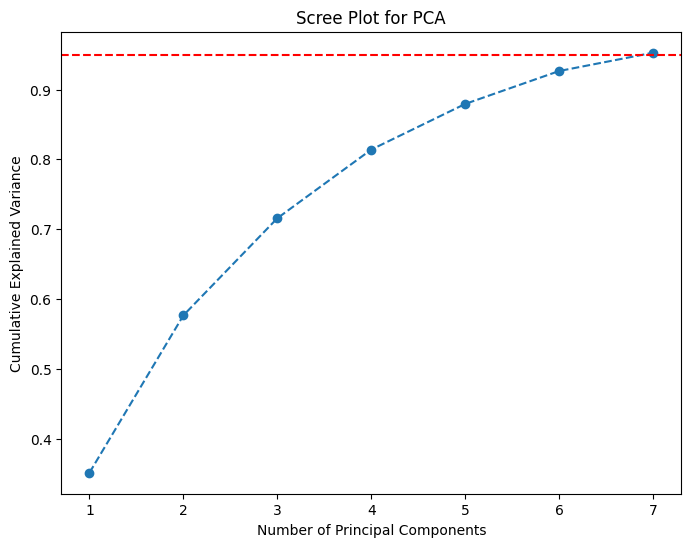

In [18]:
# Scree Plot
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

In [19]:
# Print Summary
print(f"Original 'org_name' had {org_encoded.shape[1]} dimensions, reduced to {org_pca_transformed.shape[1]} components.")
print(f"Final PCA components for modeling: {pca_transformed.shape[1]}")
print(f"Explained Variance by selected components: {explained_variance[-1]:.2f}")

Original 'org_name' had 60 dimensions, reduced to 30 components.
Final PCA components for modeling: 7
Explained Variance by selected components: 0.95


In [20]:
pca_df.to_csv("pca_transformed_data.csv", index=False)

In [21]:
# check PCA components are orthogonal
product = np.dot(pca.components_[0],pca.components_[1])
product.round(5)

-0.0

---------------------------------

In [22]:
import pandas as pd
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split
import pymc as pm
import pytensor.tensor as at
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import (
    StandardScaler,    # current scaler
    MinMaxScaler,      # Scales features to [0,1]
    RobustScaler,      # Uses median and quantiles - better with outliers
    QuantileTransformer,  # Makes uniform or normal distribution
    PowerTransformer   # Makes data more Gaussian
)

In [ ]:
# drive.mount('/content/drive')
# shared_path = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pytensor.tensor as pt

In [24]:
# Load PCA-transformed Data
pca_df = pd.read_csv('pca_transformed_data.csv')

# Select first 9 PCA components based on Scree plot
num_components = 9
X_pca = pca_df.iloc[:, :num_components]  # Use only top components

# Load Original Data to get the Target Variable (`los`)
df_original = pd.read_csv("mimiccomb_processed_updated.csv")
y = df_original["los"]  # ICU Stay Duration

# Standardize Features and Target
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X_pca)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 2184 samples
Testing set size: 547 samples


In [ ]:
# # Define Bayesian Linear Regression Model
# test_score_bayesian = pm.Model(coords={"predictors": range(num_components)})

# with test_score_bayesian:
#     # posterior variance - using a smaller value since the data is now scaled
#     sigma = pm.HalfNormal("sigma", 1)

#     # Prior for coefficients - using smaller variances since features are scaled
#     beta = pm.Normal("beta", 0, 1, dims="predictors")
#     beta0 = pm.Normal("beta0", 0, 1)  # intercept

#     # Linear model
#     mu = beta0 + at.dot(X_train, beta)

#     # Likelihood
#     y_hat = pm.Normal("y_hat", mu=mu, sigma=sigma, observed=y_train)

# # performing the Bayesian inference for your model using Markov Chain Monte Carlo (MCMC) sampling

# with test_score_bayesian:
#     sample = pm.sample(
#         draws=2000,           # Number of samples to draw
#         tune=1000,            # Number of tuning steps
#         chains=4,             # Number of independent chains
#         target_accept=0.95    # Target acceptance rate
#     )

# az.plot_trace(sample, var_names=["beta0", "sigma"])
# plt.tight_layout()
# plt.show()

In [76]:
# # Create the Bayesian Linear Regression model using the training data
# with pm.Model() as model:
#     # Priors for coefficients
#     alpha = pm.Normal('alpha', mu=0, sigma=1)  # Intercept
#     beta = pm.Normal('beta', mu=0, sigma=1, shape=X_train.shape[1])  # Coefficients for predictors

#     # Likelihood (linear model)
#     mu = alpha + pm.math.dot(X_train, beta)  # Linear combination of inputs

#     # Prior for noise (sigma)
#     sigma = pm.HalfNormal('sigma', sigma=1)

#     # Likelihood for the target variable (observed data)
#     likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_train)

#     # Perform MCMC sampling
#     trace = pm.sample(2000, return_inferencedata=False)

# # Compute mean predictions using trace directly
# alpha_mean = trace['alpha'].mean()
# beta_mean = trace['beta'].mean(axis=0)
# predictions = alpha_mean + np.dot(X_test, beta_mean)
# predictions_tr = alpha_mean + np.dot(X_train, beta_mean)

# # Evaluate the performance on the test set
# rmse = np.sqrt(mean_squared_error(y_test, predictions))
# r2 = r2_score(y_test, predictions)
# mae = mean_absolute_error(y_test, predictions)
# mse = mean_squared_error(y_test, predictions)
# rmse_tr = np.sqrt(mean_squared_error(y_train, predictions_tr))
# mse_tr = mean_squared_error(y_train, predictions_tr)
# mae_tr = mean_absolute_error(y_train, predictions_tr)
# r2_tr = r2_score(y_train, predictions_tr)

# print(f'MAE Test: {mae}')
# print(f'MSE Test: {mse}')
# print(f'RMSE Test: {rmse}')
# print(f'R^2 Test: {r2}')
# print(f'MAE Training: {mae_tr}')
# print(f'MSE Training: {mse_tr}')
# print(f'RMSE Training: {rmse_tr}')
# print(f'R^2 Training: {r2_tr}')


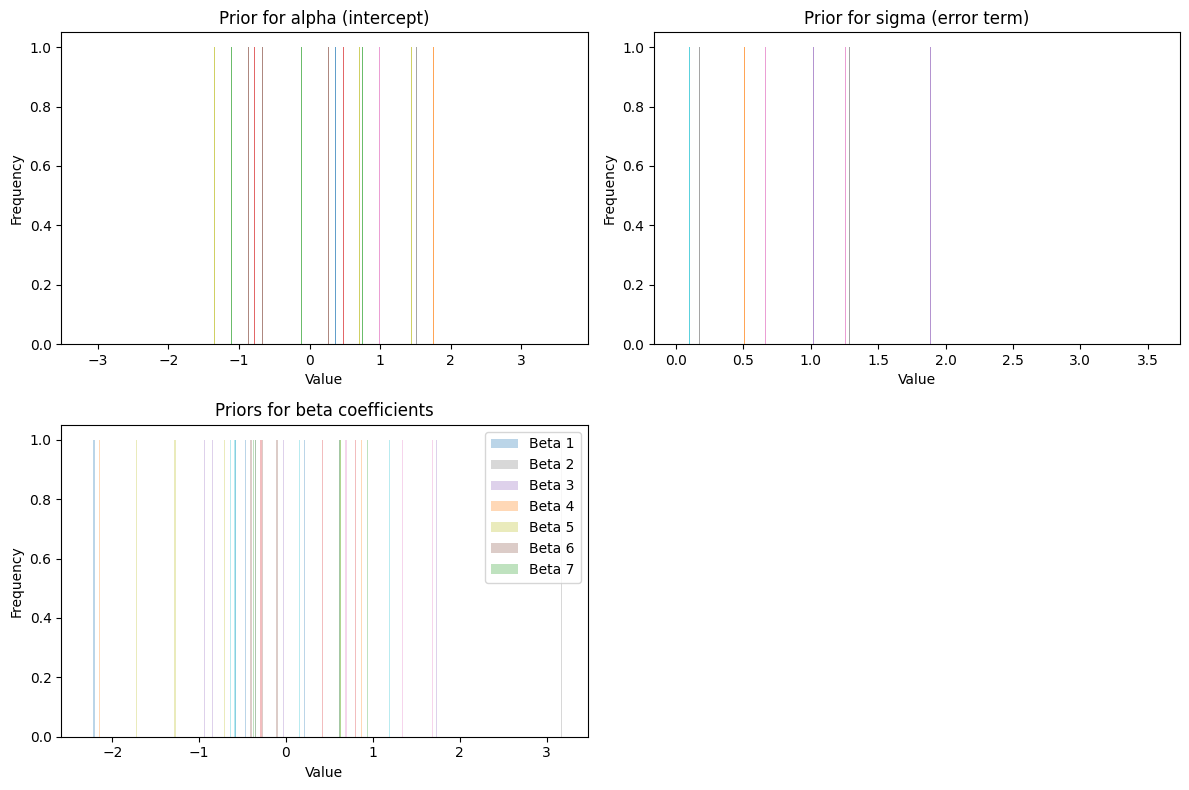

In [25]:
#Plot Prior distribution
with pm.Model() as prior_model:
    # Define the same priors as in your original model
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_train.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Sample from the prior distributions
    prior_samples = pm.sample_prior_predictive(1000)

prior_data = az.convert_to_inference_data(prior_samples)

# Plot the prior distributions
az.plot_dist(prior_data.prior["alpha"], kind="hist", label="alpha")
plt.title("Prior for alpha")
plt.show()

az.plot_dist(prior_data.prior["sigma"], kind="hist", label="sigma")
plt.title("Prior for sigma")
plt.show()

# Plot beta priors
for i in range(X_train.shape[1]):
    az.plot_dist(prior_data.prior["beta"][:, i], kind="hist", label=f"beta_{i}")
    plt.title(f"Prior for beta_{i}")
    plt.show()

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            662.47 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━╸━━   2719    0             0.75        7            332.15 draws/s   0:00:08   0:00:01

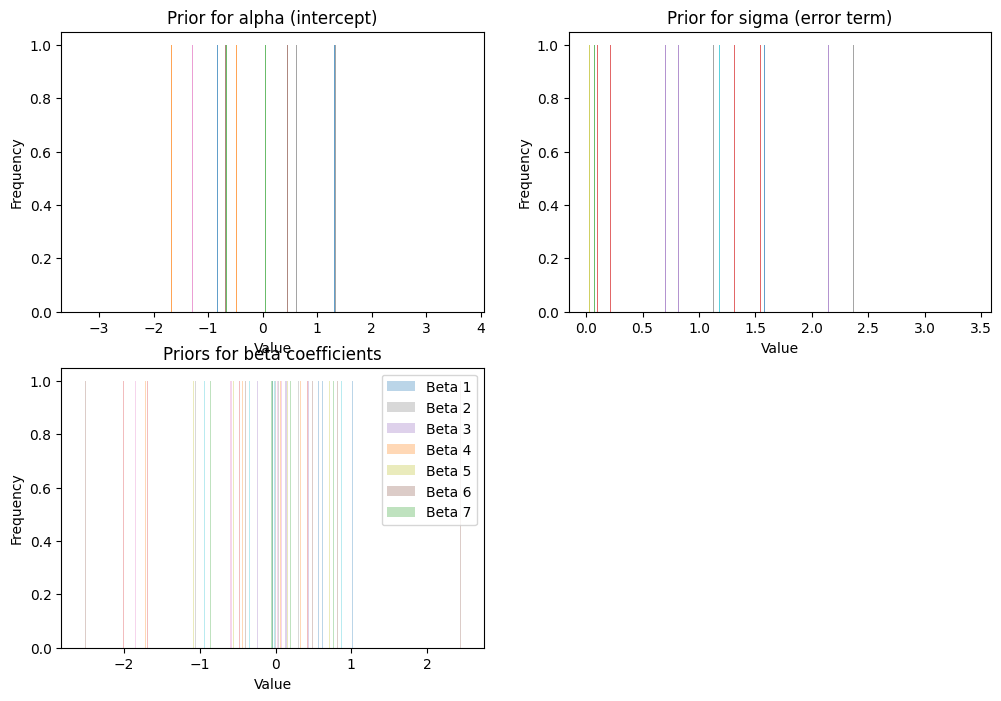

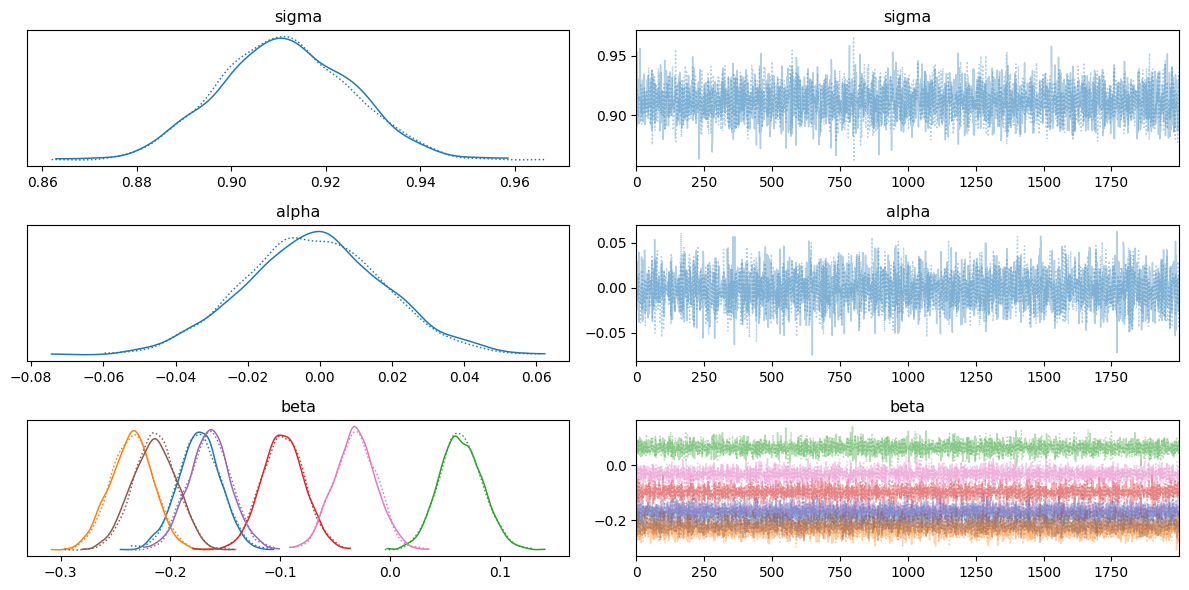

In [26]:
with pm.Model() as model:
    # Priors for coefficients
    alpha = pm.Normal('alpha', mu=0, sigma=1)  # Intercept
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_train.shape[1])  # Coefficients for predictors

    # Likelihood (linear model)
    mu = alpha + pm.math.dot(X_train, beta)  # Linear combination of inputs

    # Prior for noise (sigma)
    sigma = pm.HalfNormal('sigma', sigma=1)
    prior_samples = pm.sample_prior_predictive(1000)
    # Likelihood for the target variable (observed data)
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_train)

    # Perform MCMC sampling with return_inferencedata=True
    trace = pm.sample(2000, return_inferencedata=True)

# Now  directly use the trace for plotting
az.plot_trace(trace, var_names=['sigma', 'alpha', 'beta'])
plt.tight_layout()
plt.show()

# For predictions, you'll need to access the posterior differently:
posterior = trace.posterior
alpha_mean = float(posterior['alpha'].mean())
beta_mean = posterior['beta'].mean(["chain", "draw"]).values

# Now use these for predictions
predictions = alpha_mean + np.dot(X_test, beta_mean)
predictions_tr = alpha_mean + np.dot(X_train, beta_mean)

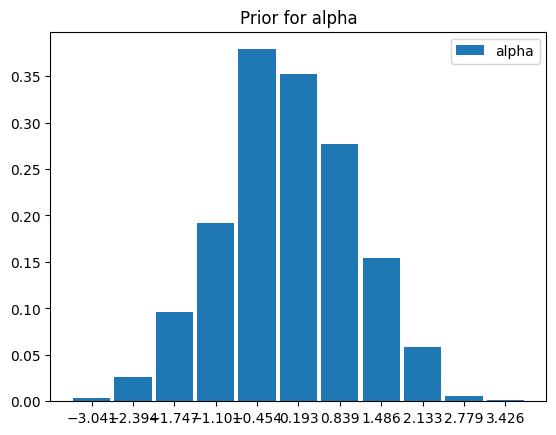

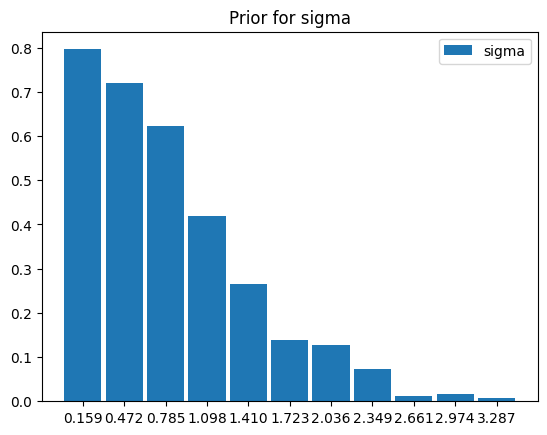

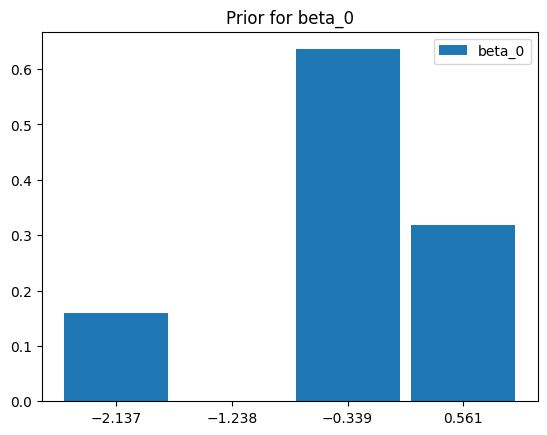

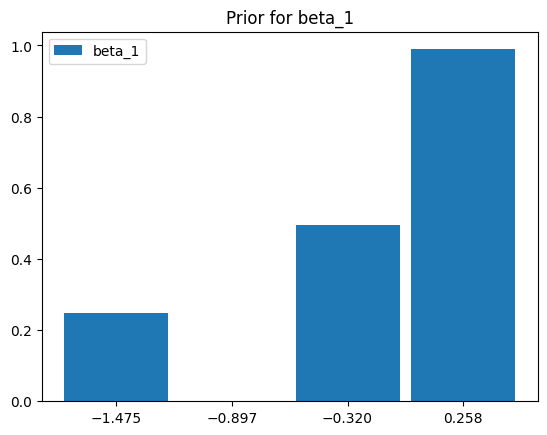

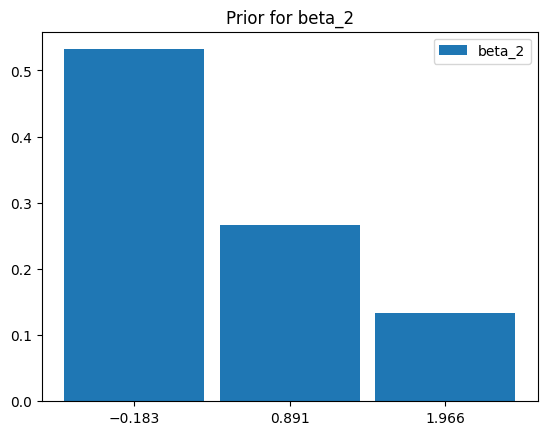

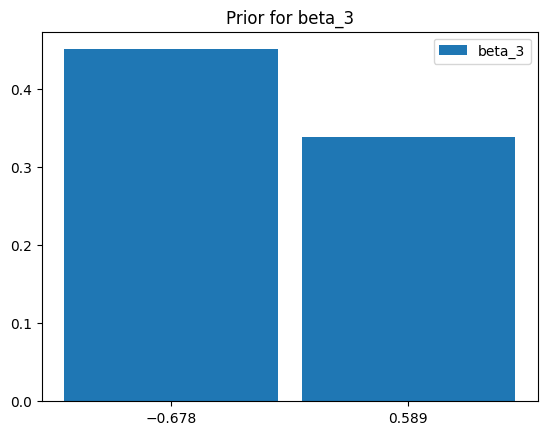

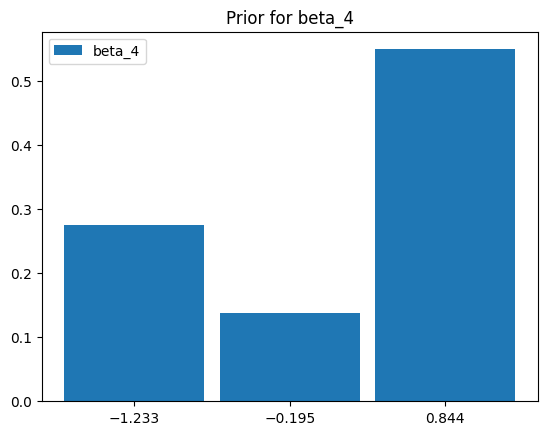

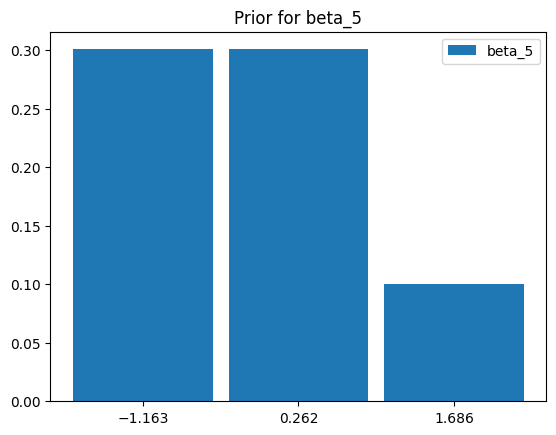

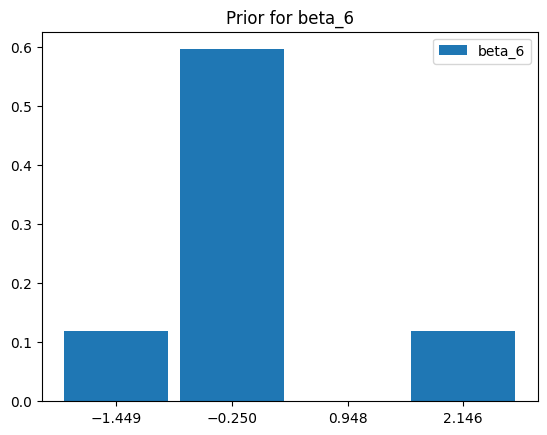

In [27]:
# Convert to InferenceData
prior_data = az.convert_to_inference_data(prior_samples)

# Plot the prior distributions
az.plot_dist(prior_data.prior["alpha"], kind="hist", label="alpha")
plt.title("Prior for alpha")
plt.show()

az.plot_dist(prior_data.prior["sigma"], kind="hist", label="sigma")
plt.title("Prior for sigma")
plt.show()

# Plot beta priors
for i in range(X_train.shape[1]):
    az.plot_dist(prior_data.prior["beta"][:, i], kind="hist", label=f"beta_{i}")
    plt.title(f"Prior for beta_{i}")
    plt.show()

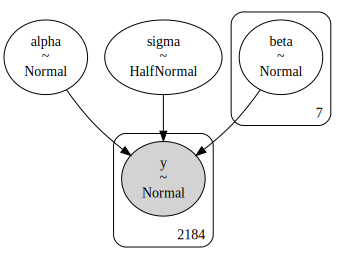

In [ ]:
pm.model_to_graphviz(model)


 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   0       0             0.00        0            0.00 draws/s     0:00:04   -:--:--

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ╸━━━━━━━━━━━━━━━━━━━━━━━━   102     0             0.01        7            23.72 draws/s    0:00:04   0:00:05

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━╸━━━━━━━━━━━━━━━━━━━━━━━   207     0             0.81        7            44.70 draws/s    0:00:04   0:00:07

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━╸━━━━━━━━━━━━━━━━━━━━━   432     0             0.93        7            84.45 draws/s    0:00:05   0:00:06

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━╺━━━━━━━━━━━━━━━━━━━   653     0             0.75        3            119.70 draws/s   0:00:05   0:00:05

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━━━╸━━━━━━━━━━━━━━━━━   918     0             0.79        7            155.00 draws/s   0:00:05   0:00:05

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━━━━╸━━━━━━━━━━━━━━━━   1073    0             0.78        3            173.75 draws/s   0:00:06   0:00:04

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━╺━━━━━━━━━━━━━━   1248    0             0.78        3            194.67 draws/s   0:00:06   0:00:03

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━╺━━━━━━━━━━━   1568    0             0.78        7            223.53 draws/s   0:00:07   0:00:03

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━╸━━━━━━━━━━   1785    0             0.78        7            241.96 draws/s   0:00:07   0:00:03

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━╸━━━━━━━   2115    0             0.78        7            265.33 draws/s   0:00:07   0:00:02

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━╺━━   2687    0             0.78        7            311.26 draws/s   0:00:08   0:00:01

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.95        7            725.31 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━╺   2930    0             0.78        3            326.97 draws/s   0:00:08   0:00:01

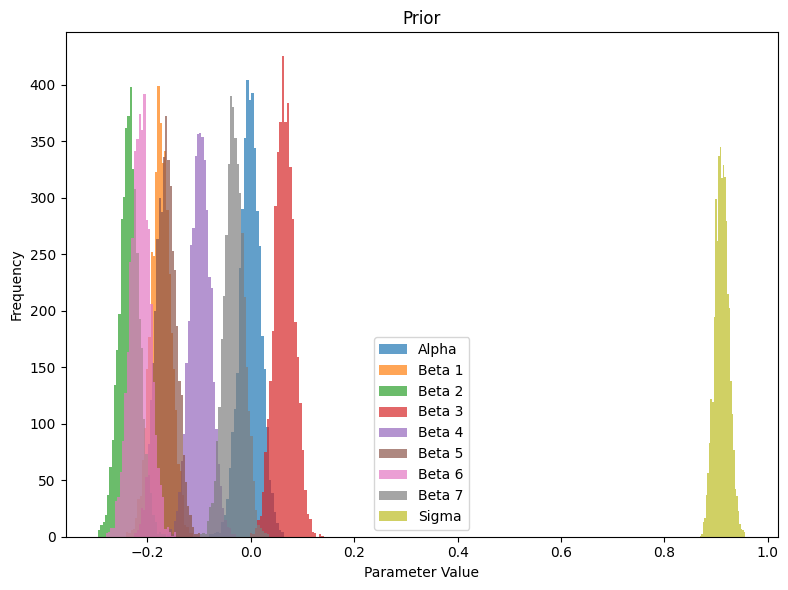

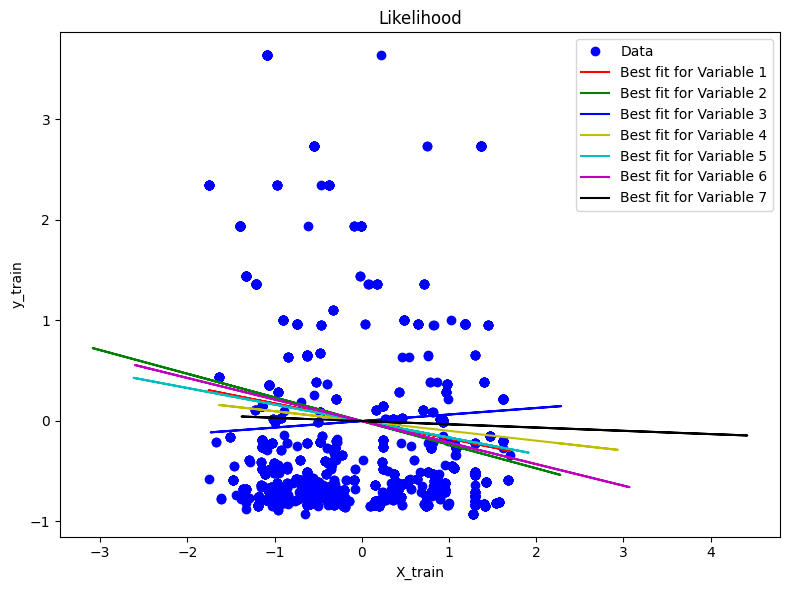

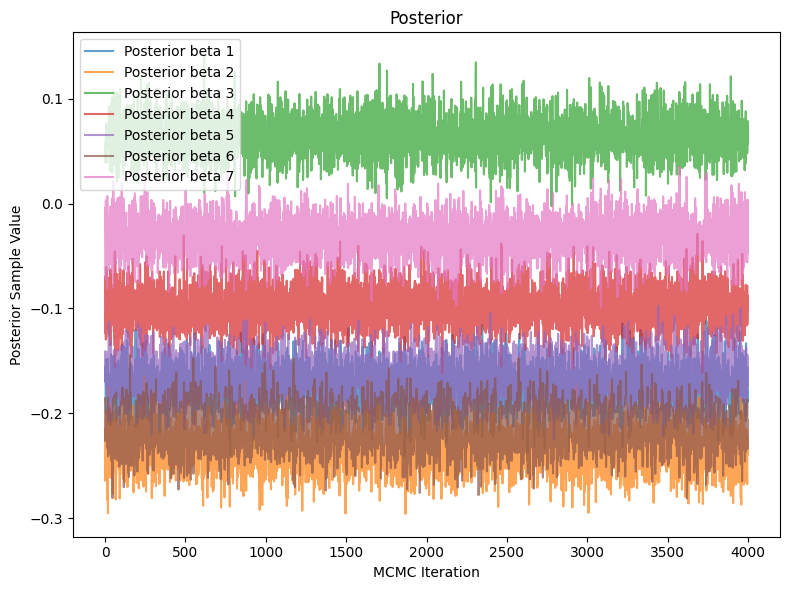

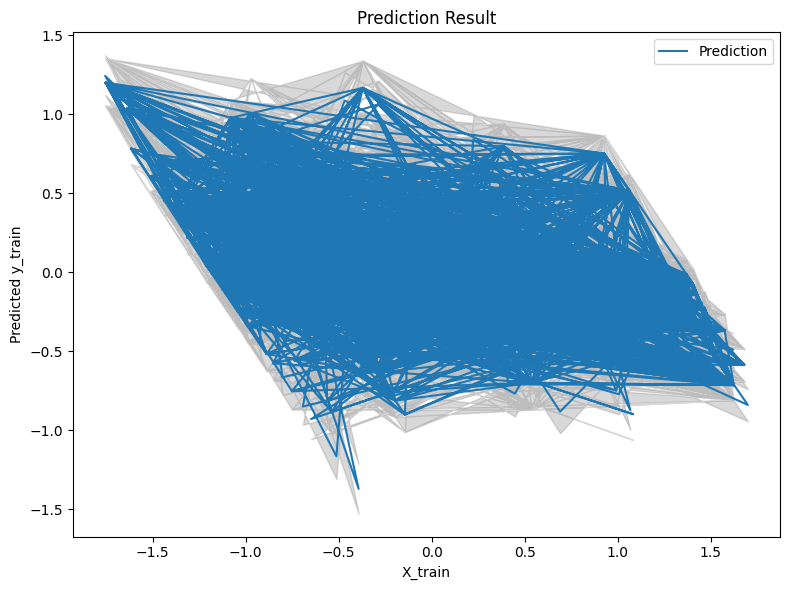

In [30]:
with pm.Model() as model:
    # Prior distributions for the regression parameters
    alpha = pm.Normal('alpha', mu=0, sigma=1)  # Intercept prior
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_train.shape[1])  # Slope prior with shape of features
    sigma = pm.HalfNormal('sigma', sigma=1)  # Prior for the error term

    # Likelihood (data model)
    # Use at.dot for matrix multiplication to calculate mu
    mu = alpha + at.dot(X_train, beta)
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_train)

    # Perform inference (sampling)
    trace = pm.sample(2000, return_inferencedata=False)

# Plotting the Prior, Likelihood, Posterior, and Result
# Prior Plot
plt.figure(figsize=(8, 6))
plt.title("Prior")
plt.hist(trace['alpha'], bins=30, alpha=0.7, label='Alpha')
for i in range(X_train.shape[1]):
    plt.hist(trace['beta'][:, i], bins=30, alpha=0.7, label=f'Beta {i+1}')
# Add sigma to the prior plot:
plt.hist(trace['sigma'], bins=30, alpha=0.7, label='Sigma')
plt.xlabel("Parameter Value")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Likelihood Plot
plt.figure(figsize=(8, 6))
plt.title("Likelihood")

# Plot the data points
plt.plot(X_train[:, 0], y_train, 'bo', label="Data")  # Plotting first variable as 'Data'

# Loop through each of the 7 variables and plot the best-fit lines with distinct colors
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']  # Distinct colors for each line
for i in range(7):
    plt.plot(X_train[:, i], trace['alpha'].mean() + trace['beta'][:, i].mean() * X_train[:, i], color=colors[i], label=f"Best fit for Variable {i+1}")

# Labels and legend
plt.xlabel("X_train")
plt.ylabel("y_train")
plt.legend()

plt.tight_layout()
plt.show()

# Posterior Plot
plt.figure(figsize=(8, 6))
plt.title("Posterior")
for i in range(X_train.shape[1]):
    plt.plot(trace['beta'][:, i], alpha=0.7, label=f'Posterior beta {i+1}')
# Add the posterior for sigma
# plt.plot(trace['sigma'], alpha=0.7, label='Posterior sigma')
plt.xlabel("MCMC Iteration")
plt.ylabel("Posterior Sample Value")
plt.legend()
plt.tight_layout()
plt.show()

# Result Plot
plt.figure(figsize=(8, 6))
plt.title("Prediction Result")
y_train_pred = trace['alpha'][:, None] + trace['beta'].dot(X_train.T)
plt.plot(X_train[:, 0], y_train_pred.mean(axis=0), label="Prediction")
plt.fill_between(X_train[:, 0], np.percentile(y_train_pred, 2.5, axis=0), np.percentile(y_train_pred, 97.5, axis=0), color='gray', alpha=0.3)
plt.xlabel("X_train")
plt.ylabel("Predicted y_train")
plt.legend()
plt.tight_layout()
plt.show()


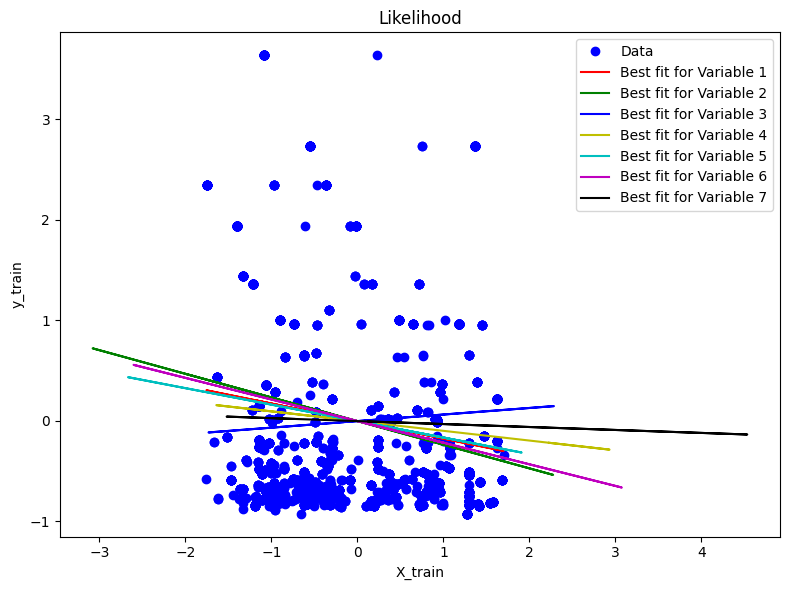

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Likelihood")

# Plot the data points
plt.plot(X_train[:, 0], y_train, 'bo', label="Data")  # Plotting first variable as 'Data'

# Loop through each of the 7 variables and plot the best-fit lines with distinct colors
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']  # Distinct colors for each line
for i in range(7):
    plt.plot(X_train[:, i], trace['alpha'].mean() + trace['beta'][:, i].mean() * X_train[:, i], color=colors[i], label=f"Best fit for Variable {i+1}")

# Labels and legend
plt.xlabel("X_train")
plt.ylabel("y_train")
plt.legend()

plt.tight_layout()
plt.show()

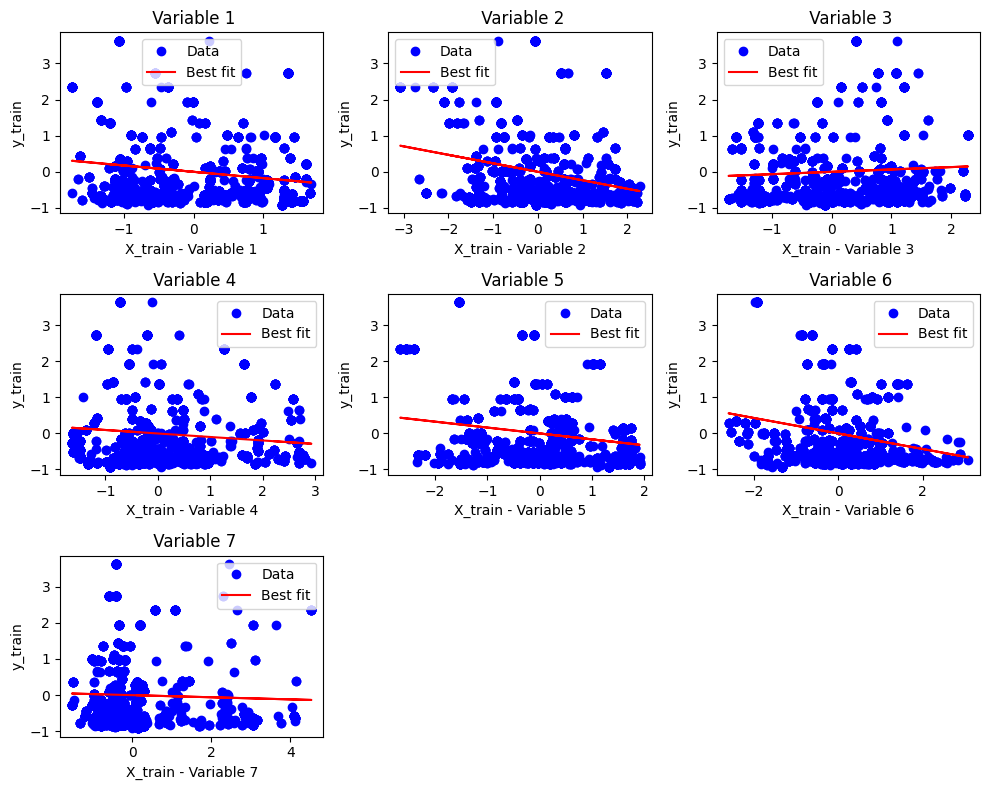

In [62]:
plt.figure(figsize=(10, 8))

# Loop through each of the 7 variables
for i in range(7):
    plt.subplot(3, 3, i+1)  # Create a subplot for each variable
    plt.title(f" Variable {i+1}")

    # Plot data points
    plt.plot(X_train[:, i], y_train, 'bo', label="Data")

    # Plot the best fit line for each variable (based on the mean of alpha and beta)
    plt.plot(X_train[:, i], trace['alpha'].mean() + trace['beta'][:, i].mean() * X_train[:, i], 'r', label="Best fit")

    plt.xlabel(f"X_train - Variable {i+1}")
    plt.ylabel("y_train")
    plt.legend()

plt.tight_layout()
plt.show()

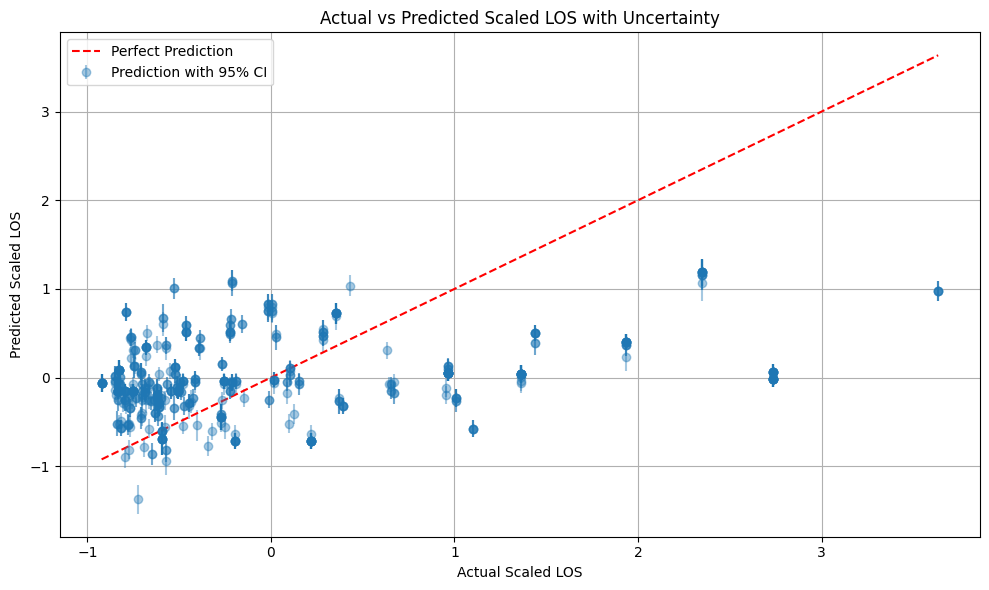

In [ ]:
# Assuming 'trace' contains your posterior samples
y_pred_samples = trace['alpha'][:, None] + trace['beta'].dot(X_test.T)
y_pred_scaled = y_pred_samples.mean(axis=0)
y_pred_std_scaled = y_pred_samples.std(axis=0)

# Calculate y_pred_original for reference (but not used for plotting in this case)
# y_pred_scaled = alpha_mean + np.dot(X_test, beta_mean)

# y_pred_std_original (not needed for scaled visualization)
# y_pred_std_original = y_scaler.inverse_transform(y_pred_std_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
# Use y_pred_scaled and y_pred_std_scaled directly for plotting
plt.errorbar(y_test, y_pred_scaled, yerr=1.96*y_pred_std_scaled, fmt='o', alpha=0.4, label='Prediction with 95% CI')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Scaled LOS')
plt.ylabel('Predicted Scaled LOS')
plt.title('Actual vs Predicted Scaled LOS with Uncertainty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
beta_mean = trace['beta'].mean(axis=0)
alpha_mean = trace['alpha'].mean()

In [51]:
y_pred_original = alpha_mean + np.dot(X_test, beta_mean)
y_test_original = y_test

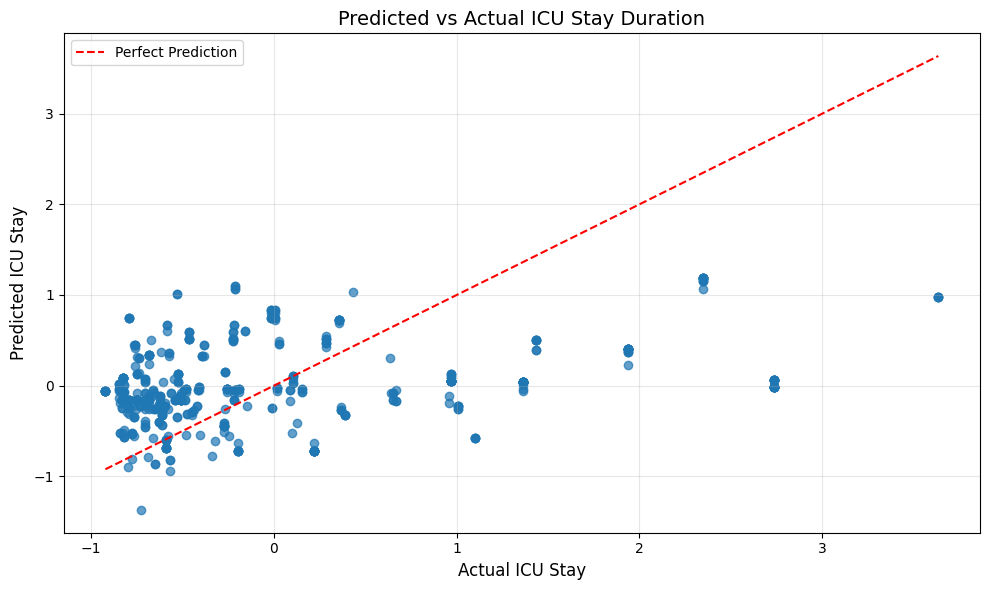

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.7)
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual ICU Stay', fontsize=12)
plt.ylabel('Predicted ICU Stay', fontsize=12)
plt.title('Predicted vs Actual ICU Stay Duration', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

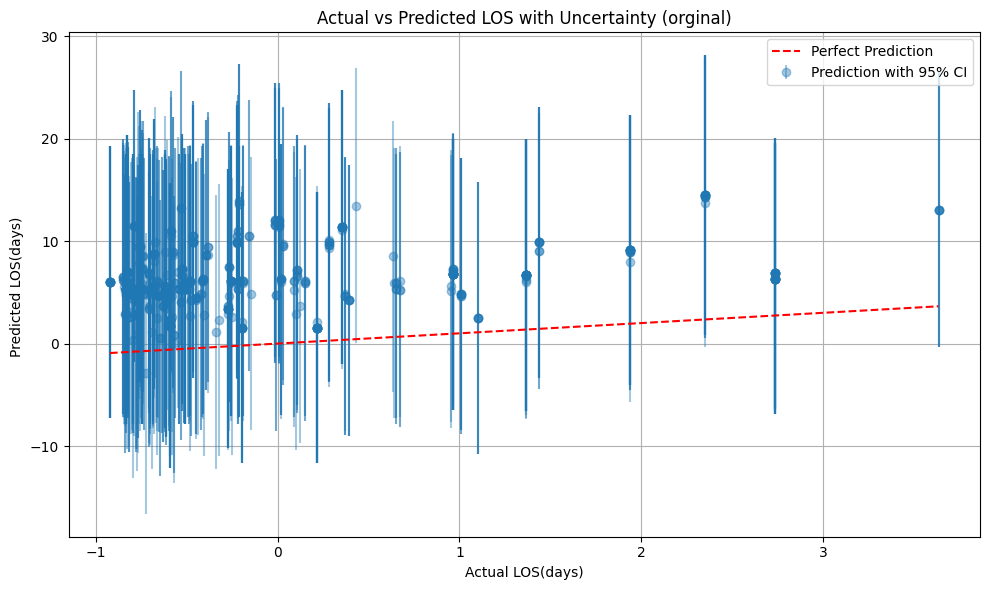

In [53]:
# 'trace' contains posterior samples
y_pred_samples = trace['alpha'][:, None] + trace['beta'].dot(X_test.T)
y_pred_scaled = y_pred_samples.mean(axis=0)
y_pred_std_scaled = y_pred_samples.std(axis=0)

# Calculate y_pred_original (you already have this)
y_pred_original = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate y_pred_std_original (This is the missing part)
y_pred_std_original = y_scaler.inverse_transform(y_pred_std_scaled.reshape(-1, 1)).flatten() # Assuming 'scaler' is your StandardScaler object

plt.figure(figsize=(10, 6))
# Now you can use y_pred_std_original here
plt.errorbar(y_test_original, y_pred_original, yerr=1.96*y_pred_std_original, fmt='o', alpha=0.4, label='Prediction with 95% CI')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual LOS(days)')
plt.ylabel('Predicted LOS(days) ')
plt.title('Actual vs Predicted LOS with Uncertainty (orginal)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
"""**Model evaluation**"""

# Get the mean of beta and beta0 from posterior samples
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

rmse_tr = np.sqrt(mean_squared_error(y_train, predictions_tr))
r2_tr = r2_score(y_train, predictions_tr)
mae_tr = mean_absolute_error(y_train, predictions_tr)
mse_tr = mean_squared_error(y_train, predictions_tr)

print(f'RMSE Test: {rmse}')
print(f'MAE Test: {mae}')
print(f'MSE Test: {mse}')
print(f'R^2 Test: {r2}')
print(f'RMSE Training: {rmse_tr}')
print(f'MAE Training: {mae_tr}')
print(f'MSE Training: {mse_tr}')
print(f'R^2 Training: {r2_tr}')

RMSE Test: 0.943276881697724
MAE Test: 0.7436354028434708
MSE Test: 0.8897712755453819
R^2 Test: 0.12349236725236212
RMSE Training: 0.9092802576689313
MAE Training: 0.7157766862225526
MSE Training: 0.826790586986478
R^2 Training: 0.17004161610098456


In [67]:
y_pred_samples = trace['alpha'][:, None] + trace['beta'].dot(X_test.T)
y_pred_scaled = y_pred_samples.mean(axis=0)
y_pred_std_scaled = y_pred_samples.std(axis=0)

# Calculate y_pred_original (you already have this)
# Calculate y_pred_std_original (This is the missing part)
y_pred_std_original = y_scaler.inverse_transform(y_pred_std_scaled.reshape(-1, 1)).flatten() # Assuming 'scaler' is your StandardScaler object

In [70]:
# Convert Predictions Back to Original Scale

y_pred_original = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Convert Actual Values Back
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate RMSE & MAE on Original Scale
mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2_original = r2_score(y_test_original, y_pred_original)
mse_original = mean_squared_error(y_test_original, y_pred_original)
print("\nModel Evaluation on Original Scale:")
print(f"MAE: {mae_original:.4f}")
print(f"MSE: {mse_original:.4f}")
print(f"RMSE: {rmse_original:.4f}")
print(f"R²: {r2_original:.4f}")


Model Evaluation on Original Scale:
MAE: 5.0525
MSE: 41.0743
RMSE: 6.4089
R²: 0.1235


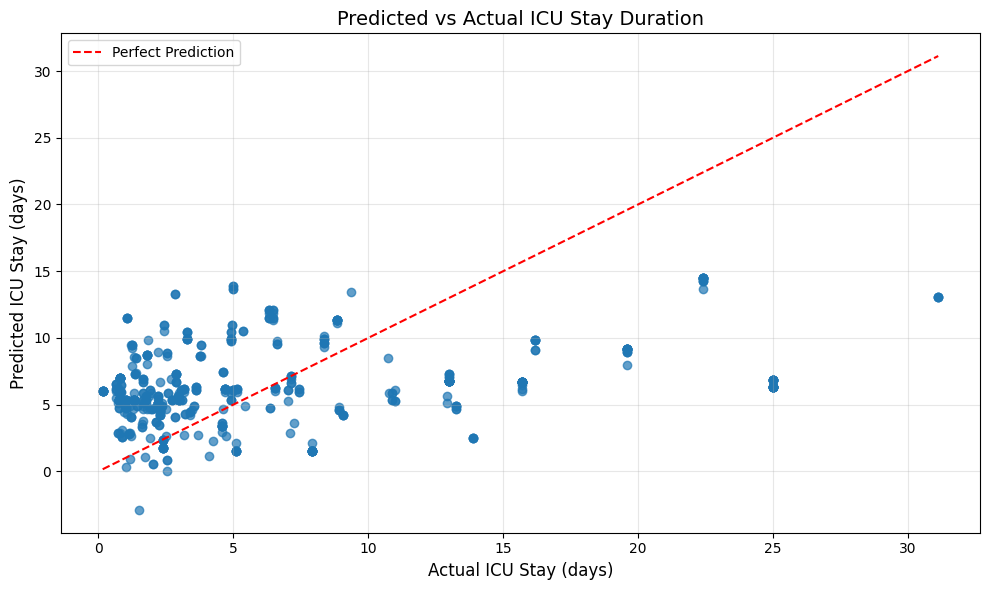

In [66]:
# Plot predicted vs actual in original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.7)
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual ICU Stay (days)', fontsize=12)
plt.ylabel('Predicted ICU Stay (days)', fontsize=12)
plt.title('Predicted vs Actual ICU Stay Duration', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()